In [28]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
import cv2
import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D,concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, concatenate, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [29]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [30]:
#original img size is 240*240
image_size = 192
smooth = 1 
num_of_aug = 1
num_epoch = 10
pul_seq = 'Flair'
sharp = False       # sharpen filter

num_of_patch = 4 #must be a square number
label_num = 5   # 1 = necrosis, 2 = tumor core, 4 = ET, 5 = complete tumor

In [31]:
def create_data(src, mask, label=False, image_size=192):
    files = glob.glob(src + mask, recursive=True)
    imgs = []
    print('Processing---', mask)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        if label:
            if label_num == 5:
                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       #only left necrosis
            if label_num == 2:
                img[img == 2] = 0       #turn edema to 0
                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       #only left ET
                img[img == 4] = 1
            img = np.asarray(img, dtype = np.int32)
            img = img[50:90]
            for s in img:
                s = cv2.resize(s, (image_size, image_size), interpolation = cv2.INTER_NEAREST)
                imgs.append(s)
        else:
            img = ((img-np.min(img)) / np.max(img)) * 2 - 1
            img = np.asarray(img, dtype = np.float32)
            img = img[50:90]
            for s in img:
                s = cv2.resize(s, (image_size, image_size), interpolation = cv2.INTER_LINEAR)
                imgs.append(s)
#         for slice in range(50,90):     #choose the slice range
#             s = img[slice,:,:]
#             img_t = cv2.resize(s, (192, 192), interpolation = cv2.INTER_LINEAR)
#             img_t = np.expand_dims(img_t, axis=2)
#             img_t = np.expand_dims(img_t, axis=0)
#             img_g = augmentation(img_t, num_of_aug)
#             for n in range(img_g.shape[0]):
#                 imgs.append(img_g[n,:,:,:])
#         break
    name = './data/sample_{}_{}_mask'.format(pul_seq, image_size) if label else './data/sample_{}_{}_image'.format(pul_seq, image_size)
    np.save(name, np.array(imgs).astype('float32'))  # save at home
    print('Saved', len(files), 'to', name)

In [32]:
def augmentation(scans, n):          #input img must be rank 4 
    datagen = ImageDataGenerator(
        featurewise_center=False,   
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=25,
        zoom_range=False)
    i = 0
    scans_g = scans.copy()
    for batch in datagen.flow(scans, batch_size=1, seed=1000): 
        scans_g = np.vstack([scans_g,batch])
        i += 1
        if i == n:
            break

    return scans_g

In [33]:
def show_image(array, array2, random = False):
    n = 5
    if random == True:
        indices = np.random.randint(len(array), size=n)
        print('Show Random {} images and masks'.format(n))
    else:
        indices = np.arange(n)
        print('Show First {} images and masks'.format(n))
    images = array[indices, :]
    masks = array2[indices, :]
    fig, axes = plt.subplots(2, 5, figsize=(15,5))
    for i in range(5):
        image = images[i, :, :]
        mask = masks[i, :, :]
        axes[0, i].set_title("Image Index = {}".format(indices[i]))
        axes[0, i].axis("off")
        axes[0, i].imshow(image, cmap='gray')
        axes[1, i].set_title("Mask Index = {}".format(indices[i]))
        axes[1, i].axis("off")
        axes[1, i].imshow(mask, cmap='gray')
    plt.show()

In [34]:
def build_model():
    inputs = Input((1, img_size, img_size))
    return model

In [35]:
create_data('./BRATS2015_Training/HGG/', '**/*{}*.mha'.format(pul_seq), label=False, image_size=192)
create_data('./BRATS2015_Training/HGG/', '**/*OT*.mha', label=True, image_size=192)

Processing--- **/*Flair*.mha
Saved 220 to ./data/sample_Flair_192_image
Processing--- **/*OT*.mha
Saved 220 to ./data/sample_Flair_192_mask


In [36]:
x = np.load('./data/sample_{}_{}_image.npy'.format(pul_seq, image_size))
y = np.load('./data/sample_{}_{}_mask.npy'.format(pul_seq, image_size))

In [37]:
x.shape

(8800, 192, 192)

In [38]:
y.shape

(8800, 192, 192)

Show Random 5 images and masks


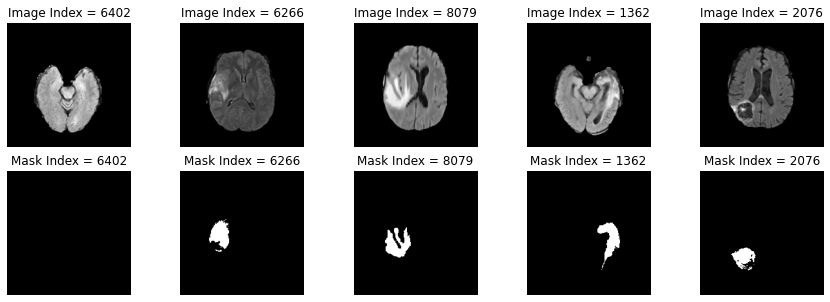

In [40]:
show_image(x, y, True)